In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import audioread
import json
import os
import itertools
import numpy as np
from PIL import Image
import cv2

### Path to Audio

In [7]:
# current SALAMI track: 1620

# audio path
ds_path = '/home/shared/cuzokwe/datasets/FotF/audio'
audio_path = '/home/shared/cuzokwe/train/audio/27.wav'
out_path = '/home/shared/cuzokwe/1614.png'

### Compute SSM - mfcc, chroma, melspectrogram

In [8]:
# return 3 self similarity matrices
def get_3ssm(audio_path):

    # load audio into np array
    y,sr = librosa.load(audio_path)
    
    #using these characteristics to achieve ~5 fps
    hop_length =  8192 
    n_fft = 16384

    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    # we can change the hop and fft size to get a matrix i dont need to change
    
    #compute chroma features and ssm
    chroma = librosa.feature.chroma_stft(S=S)
    ssm_chroma = librosa.segment.recurrence_matrix(chroma, metric='cosine', mode='affinity')

    #compute mel-spec features and ssm
    mel_spec = librosa.feature.melspectrogram(S=S)
    ssm_melspec = librosa.segment.recurrence_matrix(mel_spec, metric ='cosine', mode='affinity')
    
    #compute mfcc from mel-spec
    mfcc = librosa.feature.mfcc(S=mel_spec)
    ssm_mfcc = librosa.segment.recurrence_matrix(mfcc, metric='cosine', mode='affinity')
    print(ssm_mfcc.shape)

    return ssm_mfcc, ssm_chroma, ssm_melspec


In [9]:
a,b,c = get_3ssm(audio_path)

(750, 750)


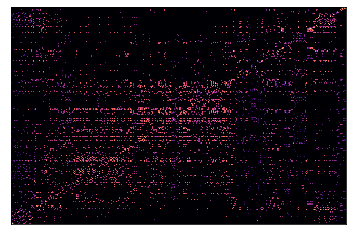

In [12]:
#mfcc
librosa.display.specshow(a)
plt.show()

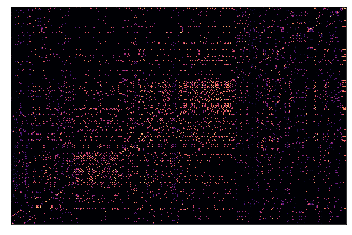

In [13]:
#chroma
librosa.display.specshow(b)
plt.show()

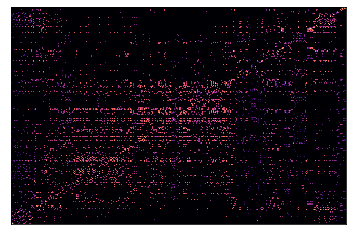

In [14]:
#melspec
librosa.display.specshow(c)
plt.show()

### Create image from feature SSMs

In [5]:
def ssm_to_png(mfcc, chroma, melspec, out_path):
    
    rgbArray = np.zeros((mfcc.shape[0],mfcc.shape[1],3), 'uint8')
    rgbArray[..., 0] = (mfcc/mfcc.max())*255
    rgbArray[..., 1] = (chroma/chroma.max())*255
    rgbArray[..., 2] = (melspec/melspec.max())*255
    img = Image.fromarray(rgbArray)
    img.save(out_path)
    
    
    

In [6]:
# Compute SSMS and create image from them

mfcc, chroma, melspec = get_3ssm(audio_path)
ssm_to_png(mfcc,chroma, melspec, out_path)

(5559, 5559)


### Get bbox XYWH & polygon values

In [5]:
def get_bbox(anno_path):
    
    # open file
    with open(anno_path) as a:
        data = json.load(a)    

    # check through all annotations and count segment labels    
    obj_list = []
    for annotation in data['annotations']:
        chorus, verse, intro, segments = []

        for segment in annotation['data']:
            if segment['value'] == "chorus":
                segment.append([label['time'], label["duration"]])
            elif segment['value'] == "verse":
                verse.append([label['time'], label["duration"]])
            elif segment['value'] == "intro":
                intro.append([label['time'], label["duration"]])

        segments.append(chorus)
        segments.append(verse)
        segments.append(intro)

        colors = ['r','g','b']
        c = 0
        for seglabels in segments:
            segcombos = itertools.product(seglabels, repeat=2)
            
            # get the segment combination bounding boxes
            for combo in segcombos:
                
                rect =  patches.Rectangle((combo[0][0], combo[1][0]), combo[0][1], combo[1][1], linewidth=1,edgecolor = colors[c], facecolor = 'none')
                bound = rect.get_bbox()
                
                px = np.arange(bound.x0, bound.x1, 0.5)
                py = np.arange(bound.y0, bound.y1, 0.5)

                poly = itertools.product(px, py)
                
                obj = {
                    "bbox": [bound.x0, bound.y0, bound.x1, bound.y1],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": c,
                }
                obj_list.append(obj)
                
            c = c+1
    return obj_list

### bbox function scratch -- will delete

In [ ]:


anno = '/home/shared/cuzokwe/datasets/SALAMI/references/SALAMI_1620.jams'

# open file
with open(anno) as a:
    data = json.load(a)  
        
# Check through all annotations and count segment labels    
obj_list = []
for annotation in data['annotations']:
    chorus = []
    verse = []
    intro = []
    overall = []

    for label in annotation['data']:
        if label['value'] == "chorus":
            chorus.append([label['time'], label["duration"]])
        elif label['value'] == "verse":
            verse.append([label['time'], label["duration"]])
        elif label['value'] == "intro":
            intro.append([label['time'], label["duration"]])

    overall.append(chorus)
    overall.append(verse)
    overall.append(intro)

    colors = ['r','g','b']
    c = 0
    for timings in overall:
        print(*timings)
        num_of_time_labels = []
        for i in range(len(timings)):
            num_of_time_labels.append(i)

        time_combos = itertools.product(timings, repeat=2)
        #print(*time_combos)
        for time in time_combos:
        #    print(*time)
            r = np.array([r])
        
            rect =  patches.Rectangle((time[0][0], time[1][0]), time[0][1], time[1][1], linewidth=1,edgecolor = colors[c], facecolor = 'none')
            test = rect.get_bbox()
            
            ll = np.array([test.x0, test.y0])  # lower-left
            ur = np.array([test.x1, test.y1])  # upper-right
            
            xy_pts = r[:,[0,1]]

            inidx = np.all(np.logical_and(ll <= xy_pts, xy_pts <= ur), axis=1)
            inbox = r[inidx]
            
        c = c+1
        
plt.title('Affinity Matrix (mfcc) wth SALAMI boundary lines - Annotation 1')
plt.show()

## Retrieve JAMS Label Distribution

In [15]:
annos = '/home/shared/cuzokwe/datasets/SALAMI/references/'
audio = '/home/shared/cuzokwe/datasets/SALAMI/audio'
label_count_dict = {}
# For each ~available~ file in SALAMI dataset
# For each data in the annotations, log the count the label (value)

# Parse through available audio tags
for file in os.listdir(audio):
    
    anno = annos + "SALAMI_" + file.split(".")[0] + '.jams'
    if os.path.exists(anno):
        
        # Load our annotation jams file as json
        with open(anno) as a:
            data = json.load(a)

        # Check through all annotations and count segment labels       
        for annotation in data['annotations']:
            for label in annotation['data']:
                if label['value'] in label_count_dict:
                    label_count_dict[label['value']] = label_count_dict[label['value']] + 1
                else:
                    label_count_dict[label['value']] = 1
                
        #label = json.dumps(data['annotations'][0]['data'][1]['value'])
        #xy = json.dumps(data['annotations'][0]['data'][1]['time'])
        #wh = json.dumps(data['annotations'][0]['data'][1]['duration'])

        #print(label)
        #print(xy)
        #print(wh)
        
         #print(json.dumps(data['annotations'][0]['data'][0]['value'], indent = 4, sort_keys=True))

### Format Dictionary for Detectron Model

In [ ]:
ds_dir = '/home/shared/cuzokwe/datasets/SALAMI'
annos = '/home/shared/cuzokwe/datasets/SALAMI/references/'
audio = '/home/shared/cuzokwe/datasets/SALAMI/audio'

def get_audio_dicts(ds_dir):
    
    annos = ds_dir + '/references'

    dataset_annos = []
    # Parse through available audio tags
    for file in os.listdir(audio):

        anno = annos + "/SALAMI_" + file.split(".")[0] + '.jams'
        if os.path.exists(anno):
            record = {}
            
            img = ds_dir + "/images/"+ file.split(".")[0] + '.png'
            if os.path.exists(img):
                record["file_name"] = img
            else:
                mfcc, chroma, melspec = get_3ssm(audio)
                ssm_to_png(mfcc, chroma, melspec, img)
                record["file_name"] = img                
            
            record["image_id"] = file.split(".")[0]
            
            img = cv2.imread(img)
            dimensions = img.shape
            record["height"] = dimensions[0]
            record["width"] = dimensions[1]
        
            objs = get_bbox(anno)
            record["annotations"] = objs
            
        dataset_annos.append(record)
    return dataset_annos 
    